In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             roc_auc_score)
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn import svm
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier

PATH = ''

In [ ]:
!pip install gdown
import gdown

In [ ]:
def download_csv_from_drive(url, output_filename):
    file_id = url.split('/')[-2]
    direct_url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(direct_url, output_filename, quiet=False)

download_csv_from_drive('https://drive.google.com/file/d/1HaOfpfVv_w4lHxWeiK0P_mizls8aZkRE/view?usp=sharing', 'pns2019.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1HaOfpfVv_w4lHxWeiK0P_mizls8aZkRE
From (redirected): https://drive.google.com/uc?id=1HaOfpfVv_w4lHxWeiK0P_mizls8aZkRE&confirm=t&uuid=f033feda-7497-42d9-beb2-84e139544795
To: /content/pns2019.csv
100%|██████████| 922M/922M [00:15<00:00, 61.0MB/s]


In [ ]:
COLUMNS = [
    "C006", "C008", "M001", "N00101", "N010", "N011", "N014", "P00104",
    "P00404","P00901", "P01101", "P013", "P015", "P018", "P02001", "P02002",
    "P023", "P02501", "P02602", "P027","P034", "P044", "P04501", "P04502",
    "P050", "Q03001", "Q03002", "V0025A", "V00291", "Q02901"
]

column_names = {
    'C006': 'sexo',
    'C008': 'idade',
    'N00101': 'percepcao_saude',
    'N010': 'sono',
    'N011': 'cansaco',
    'N014': 'apetite',
    'P00104': 'peso',
    'P00404': 'altura',
    'P00901': 'legumes',
    'P01101': 'carne_vermelha',
    'P013': 'frango',
    'P015': 'peixe',
    'P018': 'frutas',
    'P02001': 'suco_industrializado',
    'P02002': 'refrigerante',
    'P023': 'leite',
    'P02501': 'alimentos_doces',
    'P02602': 'lanches',
    'P027': 'alcool',
    'P034': 'exercicio_recente',
    'P044': 'esforco_domestico',
    'P04501': 'tv',
    'P04502': 'eletronicos',
    'P050': 'tabaco',
    'Q03001': 'diagnostico',
    'Q03002': 'diabetes_gravidez',
    'Q02901': 'exame_acucar',
    'V00291': 'peso_amostra_morador'
}



In [ ]:
file = os.path.abspath('/content/pns2019.csv')
df = pd.read_csv(file, usecols=COLUMNS)
df.shape

(293726, 30)

In [ ]:
df['V0025A'].value_counts()

V0025A
0.0    126981
1.0     94114
9.0     58287
Name: count, dtype: int64

In [ ]:
df2 = pd.DataFrame(df[df['V0025A'] == 1.0])
df2 = pd.DataFrame(df2[df2['M001'] == 1.0]).reset_index(drop=True)
df2.rename(columns=column_names, inplace=True)
df2.shape

(90846, 30)

In [ ]:
df2.isna().sum()[df2.isna().sum() > 0]


peso                   892
altura                 892
diagnostico           6773
diabetes_gravidez    86354
dtype: int64

In [ ]:
df2.isna().sum()[df2.isna().sum() > 0]


peso                   892
altura                 892
diagnostico           6773
diabetes_gravidez    86354
dtype: int64

In [ ]:
df2['exame_acucar'].value_counts(dropna=False)

exame_acucar
1.0    39594
2.0    17433
3.0    13338
5.0     8953
6.0     6773
4.0     4755
Name: count, dtype: int64

In [ ]:
df2["diagnostico"].value_counts(dropna=False)


diagnostico
2.0    76699
1.0     7374
NaN     6773
Name: count, dtype: int64

In [ ]:
df2.shape

(90846, 30)

In [ ]:
# fill missing values with mean and calculate BMI
df2['peso'] = df2['peso'].fillna(df2['peso'].mean())
df2['altura'] = df2['altura'].fillna(df2['altura'].mean())
df2['IMC'] = df2['peso'] / ((df2['altura'] / 100) ** 2)

In [ ]:
# Update diabetes labels with criterion from PNS
# if diabetes was detected during pregnancy and is a woman then not diabetes

conds = [
    (df2['diabetes_gravidez'] == 1) & (df2['sexo'] == 2),
    (df2['diagnostico'] == 1),
]
df2["ind_diab"] = pd.Series(np.select(conds, [0,1], 0))
df2.dropna(subset=['diagnostico'], inplace=True)
df2["ind_diab"].value_counts(dropna=False)


ind_diab
0    76972
1     7101
Name: count, dtype: int64

In [ ]:
df2.shape

(84073, 32)

In [ ]:
df2['idade'].min()

15.0

In [ ]:
df2.loc[df2['peso'].idxmin(),['peso','altura','IMC']]

peso       25.000000
altura    150.000000
IMC        11.111111
Name: 21847, dtype: float64

In [ ]:
df2.loc[df2['altura'].idxmax(),['peso','altura','IMC']]

peso      120.000000
altura    206.000000
IMC        28.277877
Name: 79461, dtype: float64

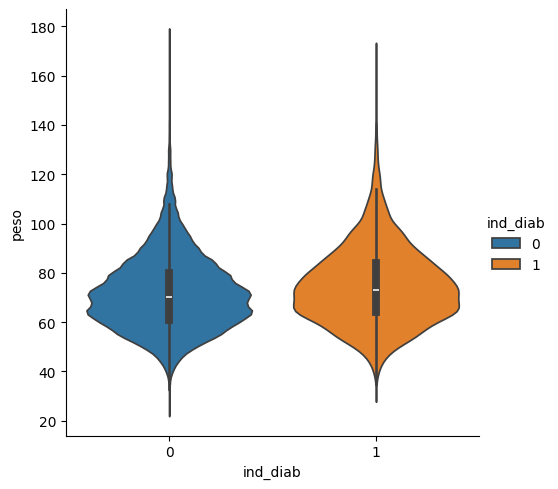

In [ ]:
sns.catplot(data=df2[['peso','ind_diab']], x="ind_diab", y="peso", hue="ind_diab", kind="violin")

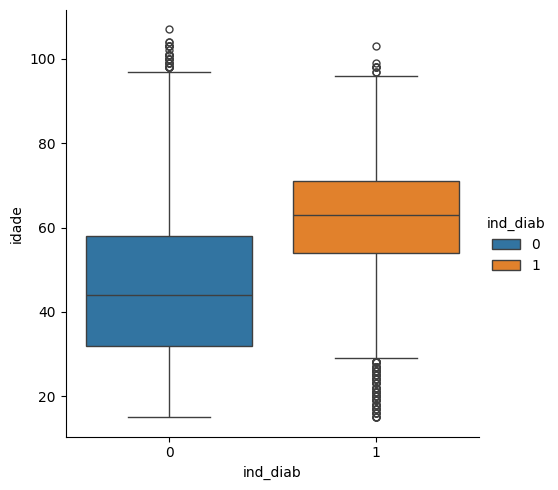

In [ ]:
sns.catplot(data=df2[['idade','ind_diab']], x="ind_diab", y="idade", hue="ind_diab", kind="box")

<Figure size 1000x600 with 0 Axes>

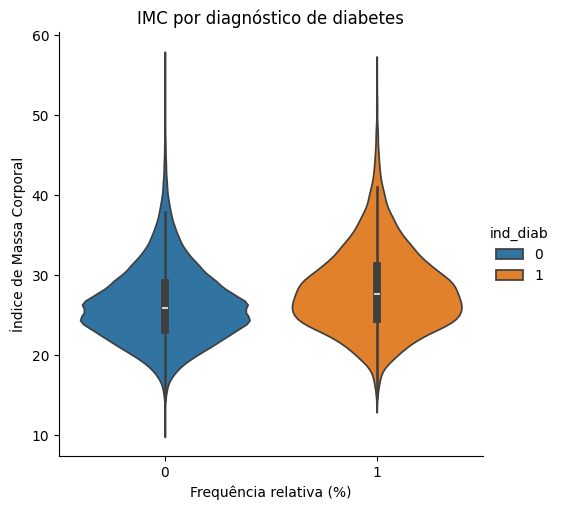

In [ ]:
plt.figure(figsize=(10, 6))

sns.catplot(data=df2[['IMC','ind_diab']], x="ind_diab", y="IMC",
            hue="ind_diab", kind="violin",estimator='median',)
plt.ylabel('Índice de Massa Corporal')
plt.xlabel('Frequência relativa (%)')
plt.title('IMC por diagnóstico de diabetes')
plt.show()

In [ ]:
df2['z_score_IMC'] = np.abs((df2['IMC'] - df2['IMC'].mean()) / df2['IMC'].std())
df2['z_score_idade'] = np.abs((df2['idade'] - df2['idade'].mean()) / df2['idade'].std())

threshold = 3
df2 = df2[df2['z_score_IMC'] <= threshold]
df2 = df2[df2['z_score_idade'] <= threshold]

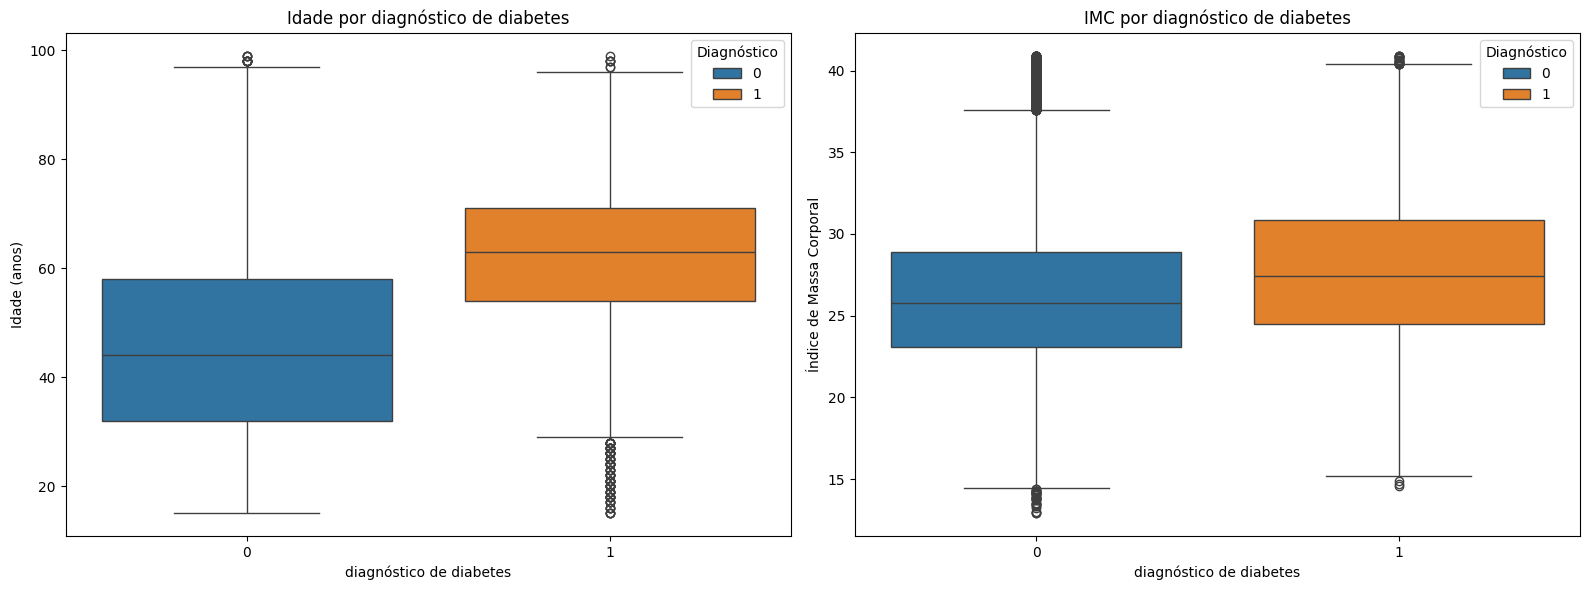

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=df2[['idade','ind_diab']], x="ind_diab", y="idade", hue="ind_diab", ax=axes[0])
sns.boxplot(data=df2[['IMC','ind_diab']], x="ind_diab", y="IMC", hue="ind_diab", ax=axes[1])
axes[0].set_xlabel('diagnóstico de diabetes')
axes[0].set_ylabel('Idade (anos)')
axes[0].set_title('Idade por diagnóstico de diabetes')
axes[0].legend(title='Diagnóstico')
axes[1].set_ylabel('Índice de Massa Corporal')
axes[1].set_xlabel('diagnóstico de diabetes')
axes[1].set_title('IMC por diagnóstico de diabetes')
axes[1].legend(title='Diagnóstico')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

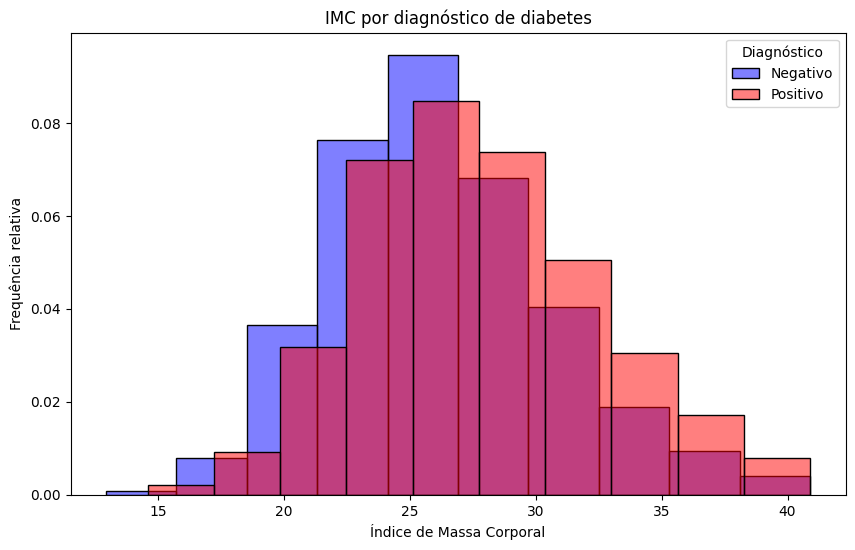

In [ ]:
# Separate data based on the class
class_0 = df2[df2['ind_diab'] == 0]['IMC']
class_1 = df2[df2['ind_diab'] == 1]['IMC']

# Plot histograms
plt.figure(figsize=(10, 6))
sns.histplot(class_0, bins=10, kde=False,  color='blue', label='Negativo', stat='density', alpha=0.5)
sns.histplot(class_1, bins=10, kde=False,  color='red', label='Positivo', stat='density', alpha=0.5)
means = df2.groupby('ind_diab')['IMC'].mean()

# Add labels and legend
plt.xlabel('Índice de Massa Corporal')
plt.ylabel('Frequência relativa')
plt.title('IMC por diagnóstico de diabetes')
plt.legend(title='Diagnóstico')

# Show plot
plt.show()


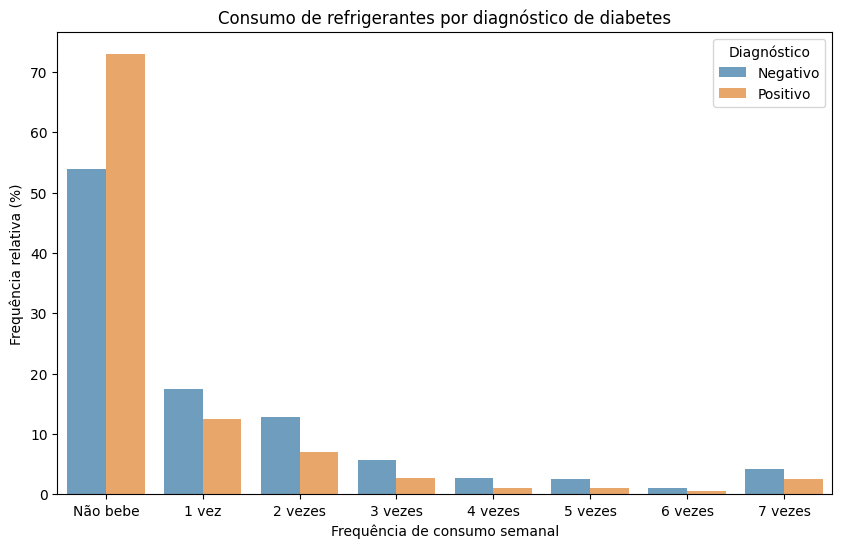

In [ ]:
counts = df2.groupby(['ind_diab', 'refrigerante']).size().unstack().fillna(0)

# Calculate relative frequencies
relative_freq = counts.div(counts.sum(axis=1), axis=0) * 100

relative_freq = relative_freq.stack().reset_index(name='percentage')
category_mapping = {
    0 : 'Não bebe',
    1 : '1 vez',
    2 : '2 vezes',
    3 : '3 vezes',
    4 : '4 vezes',
    5 : '5 vezes',
    6 : '6 vezes',
    7 : '7 vezes'
}
class_mapping = {0: 'Negativo', 1: 'Positivo'}
relative_freq['refrigerante'] = relative_freq['refrigerante'].map(category_mapping)
relative_freq['ind_diab'] = relative_freq['ind_diab'].map(class_mapping)
# Plot the data
plt.figure(figsize=(10, 6))

# Use seaborn to create a bar plot
refri_plt = sns.barplot(x='refrigerante', y='percentage', hue='ind_diab', data=relative_freq, alpha=0.7)

# Add labels and title
plt.xlabel('Frequência de consumo semanal')
plt.ylabel('Frequência relativa (%)')
plt.title('Consumo de refrigerantes por diagnóstico de diabetes')
plt.legend(title='Diagnóstico')

# Show plot
plt.show()


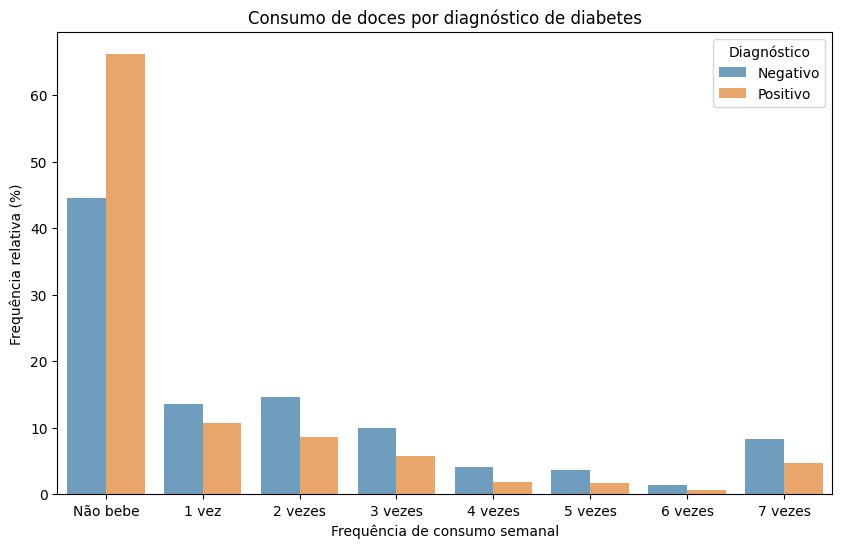

In [ ]:
counts = df2.groupby(['ind_diab', 'alimentos_doces']).size().unstack().fillna(0)

# Calculate relative frequencies
relative_freq = counts.div(counts.sum(axis=1), axis=0) * 100

relative_freq = relative_freq.stack().reset_index(name='percentage')
category_mapping = {
    0 : 'Não bebe',
    1 : '1 vez',
    2 : '2 vezes',
    3 : '3 vezes',
    4 : '4 vezes',
    5 : '5 vezes',
    6 : '6 vezes',
    7 : '7 vezes'
}
class_mapping = {0: 'Negativo', 1: 'Positivo'}
relative_freq['alimentos_doces'] = relative_freq['alimentos_doces'].map(category_mapping)
relative_freq['ind_diab'] = relative_freq['ind_diab'].map(class_mapping)
# Plot the data
plt.figure(figsize=(10, 6))

# Use seaborn to create a bar plot
doces_plt = sns.barplot(x='alimentos_doces', y='percentage', hue='ind_diab', data=relative_freq, alpha=0.7)

# Add labels and title
plt.xlabel('Frequência de consumo semanal')
plt.ylabel('Frequência relativa (%)')
plt.title('Consumo de doces por diagnóstico de diabetes')
plt.legend(title='Diagnóstico')

# Show plot
plt.show()

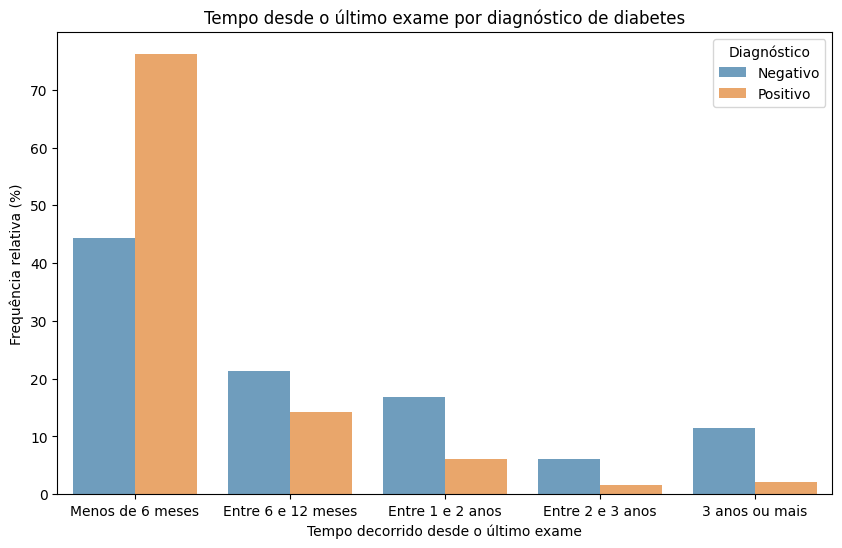

In [ ]:
counts = df2.groupby(['ind_diab', 'exame_acucar']).size().unstack().fillna(0)

# Calculate relative frequencies
relative_freq = counts.div(counts.sum(axis=1), axis=0) * 100

relative_freq = relative_freq.stack().reset_index(name='percentage')
category_mapping = {
    1 : 'Menos de 6 meses',
    2 : 'Entre 6 e 12 meses',
    3 : 'Entre 1 e 2 anos',
    4 : 'Entre 2 e 3 anos',
    5 : '3 anos ou mais',
    6 : 'Nunca fez exame'
}
class_mapping = {0: 'Negativo', 1: 'Positivo'}
relative_freq['exame_acucar'] = relative_freq['exame_acucar'].map(category_mapping)
relative_freq['ind_diab'] = relative_freq['ind_diab'].map(class_mapping)
# Plot the data
plt.figure(figsize=(10, 6))

# Use seaborn to create a bar plot
exame_plt = sns.barplot(x='exame_acucar', y='percentage', hue='ind_diab', data=relative_freq, alpha=0.7)

# Add labels and title
plt.xlabel('Tempo decorrido desde o último exame')
plt.ylabel('Frequência relativa (%)')
plt.title('Tempo desde o último exame por diagnóstico de diabetes')
plt.legend(title='Diagnóstico')

# Show plot
plt.show()

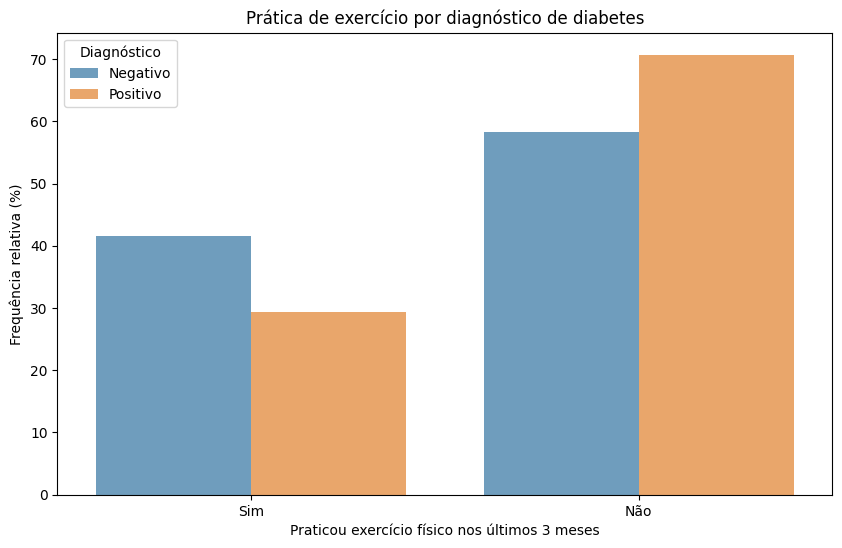

In [ ]:
counts = df2.groupby(['ind_diab', 'exercicio_recente']).size().unstack().fillna(0)

# Calculate relative frequencies
relative_freq = counts.div(counts.sum(axis=1), axis=0) * 100

relative_freq = relative_freq.stack().reset_index(name='percentage')
category_mapping = {
    1 : 'Sim',
    2 : 'Não'
}
relative_freq['exercicio_recente'] = relative_freq['exercicio_recente'].map(category_mapping)
class_mapping = {0: 'Negativo', 1: 'Positivo'}
relative_freq['ind_diab'] = relative_freq['ind_diab'].map(class_mapping)
# Plot the data
plt.figure(figsize=(10, 6))

# Use seaborn to create a bar plot
exercicio_plt = sns.barplot(x='exercicio_recente', y='percentage', hue='ind_diab', data=relative_freq, alpha=0.7)

# Add labels and title
plt.xlabel('Praticou exercício físico nos últimos 3 meses')
plt.ylabel('Frequência relativa (%)')
plt.title('Prática de exercício por diagnóstico de diabetes')
plt.legend(title='Diagnóstico')

# Show plot
plt.show()

In [ ]:
def calc_rel_freq(data, cat_name, class_name, cat_mapping=None):
    class_mapping = {0: 'Negativo', 1: 'Positivo'}
    counts = data.groupby([class_name, cat_name]).size().unstack().fillna(0)
    relative_freq = counts.div(counts.sum(axis=1), axis=0) * 100
    relative_freq = relative_freq.stack().reset_index(name='percentage')
    relative_freq[class_name] = relative_freq[class_name].map(class_mapping)
    if cat_mapping:
        relative_freq[cat_name] = relative_freq[cat_name].map(cat_mapping)

    return relative_freq

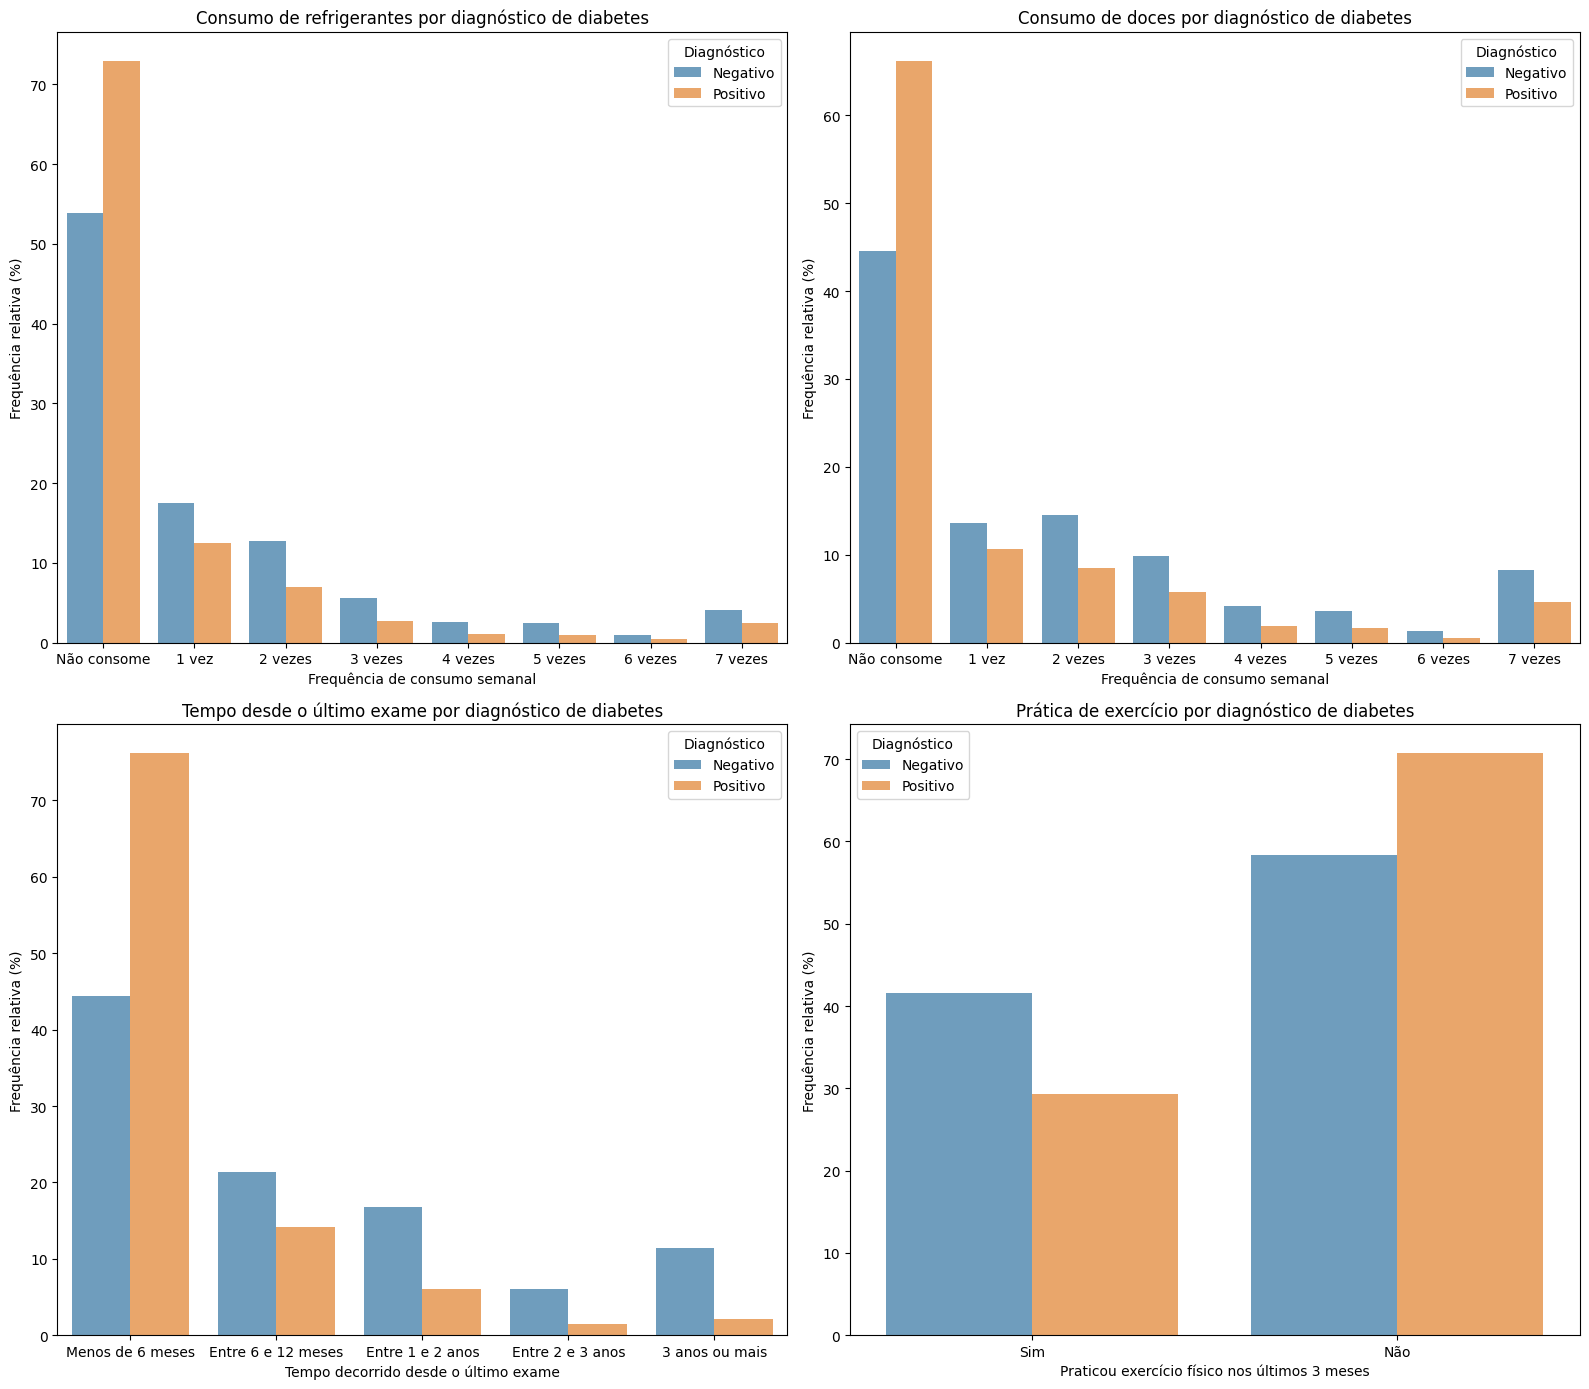

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# refrigerante
category_mapping = {
    0 : 'Não consome',
    1 : '1 vez',
    2 : '2 vezes',
    3 : '3 vezes',
    4 : '4 vezes',
    5 : '5 vezes',
    6 : '6 vezes',
    7 : '7 vezes'
}
relative_freq = calc_rel_freq(df2,'refrigerante', 'ind_diab', category_mapping)

sns.barplot(x='refrigerante', y='percentage', hue='ind_diab',
                        data=relative_freq, alpha=0.7, ax=axes[0,0])

axes[0,0].set_xlabel('Frequência de consumo semanal')
axes[0,0].set_ylabel('Frequência relativa (%)')
axes[0,0].set_title('Consumo de refrigerantes por diagnóstico de diabetes')
axes[0,0].legend(title='Diagnóstico')

# doces
relative_freq = calc_rel_freq(df2,'alimentos_doces', 'ind_diab', category_mapping)

doces_plt = sns.barplot(x='alimentos_doces', y='percentage', hue='ind_diab',
                        data=relative_freq, alpha=0.7, ax=axes[0,1])

axes[0,1].set_xlabel('Frequência de consumo semanal')
axes[0,1].set_ylabel('Frequência relativa (%)')
axes[0,1].set_title('Consumo de doces por diagnóstico de diabetes')
axes[0,1].legend(title='Diagnóstico')

# exame
category_mapping = {
    1 : 'Menos de 6 meses',
    2 : 'Entre 6 e 12 meses',
    3 : 'Entre 1 e 2 anos',
    4 : 'Entre 2 e 3 anos',
    5 : '3 anos ou mais',
    6 : 'Nunca fez exame'
}

relative_freq = calc_rel_freq(df2,'exame_acucar', 'ind_diab', category_mapping)

exame_plt = sns.barplot(x='exame_acucar', y='percentage', hue='ind_diab',
                        data=relative_freq, alpha=0.7, ax=axes[1,0])

axes[1,0].set_xlabel('Tempo decorrido desde o último exame')
axes[1,0].set_ylabel('Frequência relativa (%)')
axes[1,0].set_title('Tempo desde o último exame por diagnóstico de diabetes')
axes[1,0].legend(title='Diagnóstico')

# exercicios
category_mapping = {
    1 : 'Sim',
    2 : 'Não'
}

relative_freq = calc_rel_freq(df2,'exercicio_recente', 'ind_diab', category_mapping)

# Use seaborn to create a bar plot
exercicio_plt = sns.barplot(x='exercicio_recente', y='percentage', hue='ind_diab',
                            data=relative_freq, alpha=0.7, ax=axes[1,1])

axes[1,1].set_xlabel('Praticou exercício físico nos últimos 3 meses')
axes[1,1].set_ylabel('Frequência relativa (%)')
axes[1,1].set_title('Prática de exercício por diagnóstico de diabetes')
axes[1,1].legend(title='Diagnóstico')

plt.tight_layout()
plt.show()

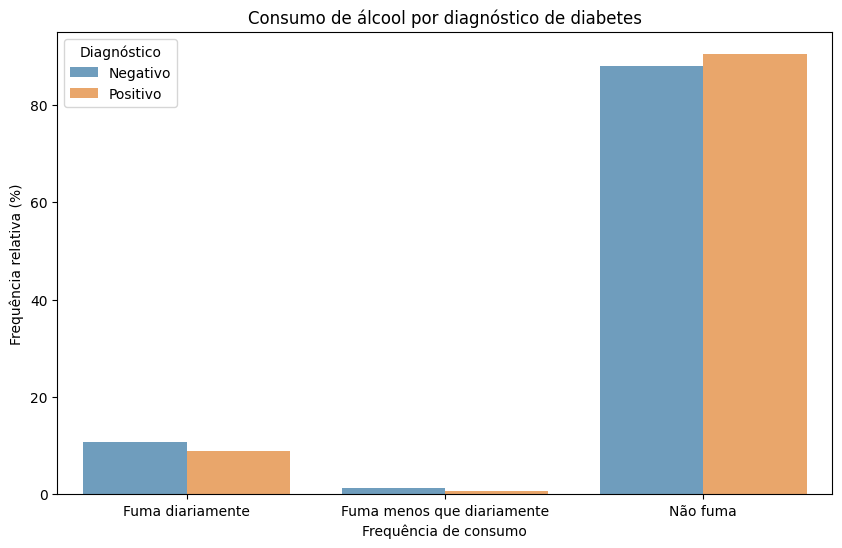

In [ ]:
counts = df2.groupby(['ind_diab', 'tabaco']).size().unstack().fillna(0)

# Calculate relative frequencies
relative_freq = counts.div(counts.sum(axis=1), axis=0) * 100

relative_freq = relative_freq.stack().reset_index(name='percentage')
category_mapping = {
    1 : 'Fuma diariamente',
    2 : 'Fuma menos que diariamente',
    3 : 'Não fuma'
}
class_mapping = {0: 'Negativo', 1: 'Positivo'}
relative_freq['tabaco'] = relative_freq['tabaco'].map(category_mapping)
relative_freq['ind_diab'] = relative_freq['ind_diab'].map(class_mapping)

# Plot the data
plt.figure(figsize=(10, 6))

# Use seaborn to create a bar plot
sns.barplot(x='tabaco', y='percentage', hue='ind_diab', data=relative_freq, alpha=0.7)

# Add labels and title
plt.xlabel('Frequência de consumo')
plt.ylabel('Frequência relativa (%)')
plt.title('Consumo de álcool por diagnóstico de diabetes')
plt.legend(title='Diagnóstico')

# Show plot
plt.show()

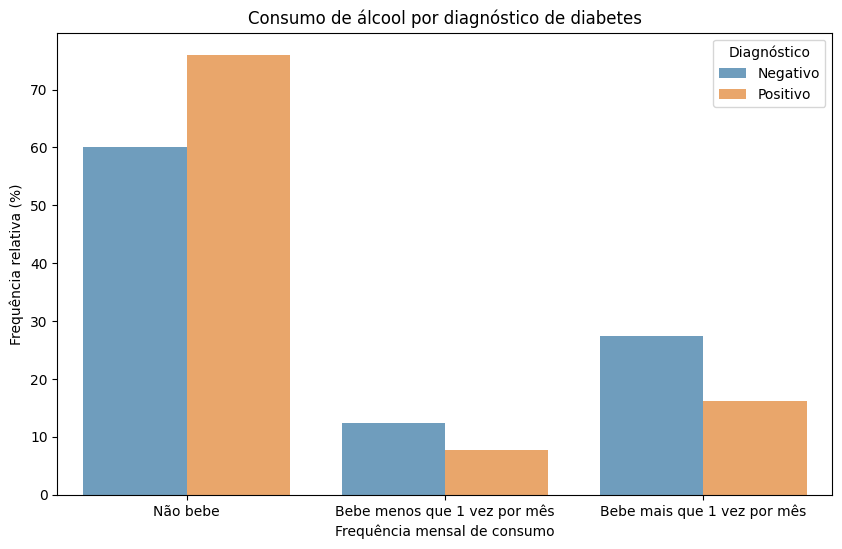

In [ ]:
counts = df2.groupby(['ind_diab', 'alcool']).size().unstack().fillna(0)

# Calculate relative frequencies
relative_freq = counts.div(counts.sum(axis=1), axis=0) * 100

relative_freq = relative_freq.stack().reset_index(name='percentage')

category_mapping = {
    1 : 'Não bebe',
    2 : 'Bebe menos que 1 vez por mês',
    3 : 'Bebe mais que 1 vez por mês'
}
class_mapping = {0: 'Negativo', 1: 'Positivo'}

relative_freq['alcool'] = relative_freq['alcool'].map(category_mapping)
relative_freq['ind_diab'] = relative_freq['ind_diab'].map(class_mapping)

# Plot the data
plt.figure(figsize=(10, 6))

# Use seaborn to create a bar plot
ax = sns.barplot(x='alcool', y='percentage', hue='ind_diab', data=relative_freq, alpha=0.7)

# Add labels and title
plt.xlabel('Frequência mensal de consumo')
plt.ylabel('Frequência relativa (%)')
plt.title('Consumo de álcool por diagnóstico de diabetes')
plt.legend(title='Diagnóstico')
# Show plot
plt.show()

In [ ]:
df2.drop(columns=['diagnostico', 'diabetes_gravidez', 'peso',
         'altura', 'z_score_IMC', 'z_score_idade'], inplace=True)

In [ ]:
df2.isna().sum()[df2.isna().sum() > 0]


Series([], dtype: int64)

In [ ]:
df2.shape

(83273, 28)

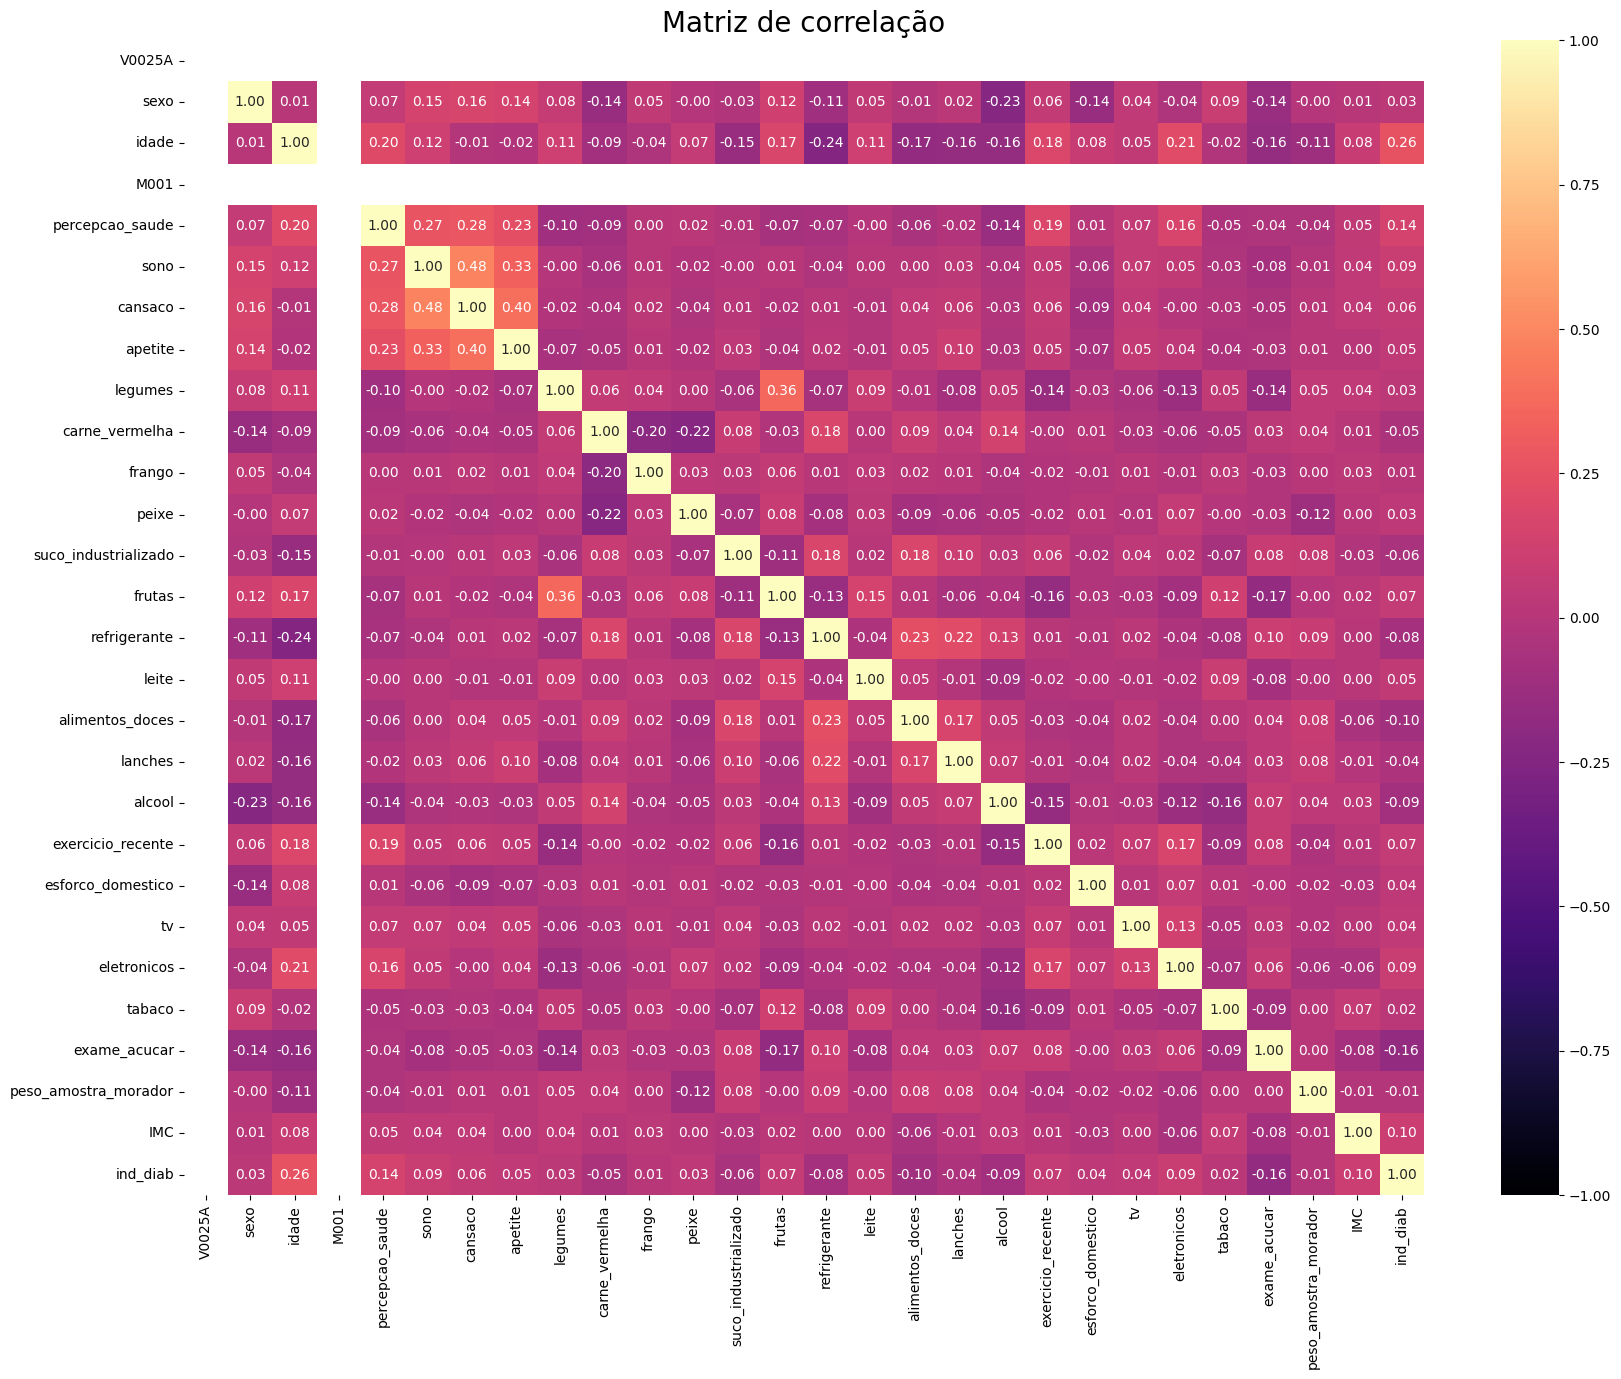

In [ ]:
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df2.corr(), annot=True, fmt=".2f", ax=ax, cmap = "magma",vmin=-1,vmax=1 )
ax.set_title("Matriz de correlação", fontsize=20)
plt.show()

In [ ]:
response_label = "ind_diab"
weight_column = "peso_amostra_morador"
numeric_columns = ['idade','IMC','legumes','carne_vermelha',
            'frango','peixe','frutas','suco_industrializado','refrigerante',
            'leite','alimentos_doces','lanches','alcool']
categorical_columns = [col for col in df2.columns
                     if col not in [response_label, weight_column, *numeric_columns]]

In [ ]:
# Normalize numerical features
transformer_norm = Normalizer(norm='l2').fit_transform(df2[numeric_columns])
numerical_normalized_df = pd.DataFrame(transformer_norm,
                                       columns=numeric_columns, index=df2.index)

# One-Hot encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df2[categorical_columns])
categorical_encoded_df = pd.DataFrame(encoded_array,
                                      columns=encoder.get_feature_names_out(),
                                      index=df2.index)

# Concatenate transformed features
transformed_data = pd.concat([categorical_encoded_df,
                              numerical_normalized_df,
                              df2[weight_column],
                              df2[response_label]], axis=1)

In [ ]:
def print_model_summary(name, y_test, y_pred)-> None:
    print(f"Model: {name}")
    print("ACCURACY OF THE MODEL:", accuracy_score(y_test, y_pred))
    print("Test Classification Report:\n", classification_report(y_test, y_pred))
    print("Conf. mat.\n", confusion_matrix(y_test, y_pred))
    print("ROC: ", roc_auc_score(y_test,y_pred))

In [ ]:
ratio_train = 0.7
ratio_test = 0.3
predictor_columns = [col for col in transformed_data.columns
                     if col not in [response_label, weight_column]]

X = transformed_data[predictor_columns]
y = transformed_data[response_label]
weights = transformed_data[weight_column]
x_train, x_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=ratio_test)

In [ ]:
# create ADASYN model to oversample the minority class

adasyn = ADASYN(random_state=42)
x_res, y_res = adasyn.fit_resample(x_train, y_train)

In [ ]:
# fit RandomForestClassifier model with weighted classes

class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

print("Class Weights:", class_weights)

rfc_model = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]},
                               random_state=42)
rfc_model.fit(x_train, y_train)
rfc_y_val_pred = rfc_model.predict(x_test)
print_model_summary(rfc_model.__class__.__name__,y_test,rfc_y_val_pred)

Class Weights: [0.54586744 5.95049   ]
Model: RandomForestClassifier
ACCURACY OF THE MODEL: 0.9171003122248018
Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     22914
           1       0.48      0.01      0.03      2068

    accuracy                           0.92     24982
   macro avg       0.70      0.51      0.49     24982
weighted avg       0.88      0.92      0.88     24982

Conf. mat.
 [[22882    32]
 [ 2039    29]]
ROC:  0.5063133423452489


In [ ]:
# Use grid search to optime hyperparameters

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_res, y_res)

# The best model found through grid search
best_model = grid_search.best_estimator_

# Validate again with the best model
y_val_pred_best = best_model.predict(x_test)

In [ ]:
grid_search.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

In [ ]:
pd.Series([estimator.get_depth() for estimator in best_model.estimators_]).describe()

count    200.000000
mean      52.200000
std        4.107843
min       42.000000
25%       49.000000
50%       52.000000
75%       55.000000
max       62.000000
dtype: float64

In [ ]:
# fit RandomForestClassifier model with ADASYN and optimized hyperparameters

rfc_model = RandomForestClassifier(n_estimators=200,max_depth=100)
rfc_model.fit(x_res,y_res)
rfc_y_val_pred = rfc_model.predict(x_test)

In [ ]:
print_model_summary(rfc_model.__class__.__name__, y_test, rfc_y_val_pred)

Model: RandomForestClassifier
ACCURACY OF THE MODEL: 0.8841165639260268
Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     22883
           1       0.29      0.27      0.28      2099

    accuracy                           0.88     24982
   macro avg       0.61      0.60      0.61     24982
weighted avg       0.88      0.88      0.88     24982

Conf. mat.
 [[21524  1359]
 [ 1536   563]]
ROC:  0.6044169485984558


In [ ]:
# fit GradientBoostingClassifier model with ADASYN

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,
    max_depth=2, random_state=0).fit(x_res,y_res)
clf_y_val_pred = clf.predict(x_test)

In [ ]:
print_model_summary(clf.__class__.__name__, y_test, clf_y_val_pred)

Model: GradientBoostingClassifier
ACCURACY OF THE MODEL: 0.8862380914258265
Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     22883
           1       0.30      0.26      0.28      2099

    accuracy                           0.89     24982
   macro avg       0.62      0.60      0.61     24982
weighted avg       0.88      0.89      0.88     24982

Conf. mat.
 [[21587  1296]
 [ 1546   553]]
ROC:  0.6034114296482238


In [ ]:
# Use stratified K-Folds cross validation on GradientBoostingClassifier model

cv = StratifiedKFold()
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    clf.fit(X.loc[train_index,],y.loc[train_index,])
    clf_y_val_pred = clf.predict(x_test)
    print(f"fold: {i}")
    print_model_summary(clf.__class__.__name__, y_test, clf_y_val_pred)


NameError: name 'clf' is not defined

In [ ]:
# fit eXtremeGradientBoostingClassifier model with ADASYN

xgb_model = XGBClassifier()
xgb_model.fit(x_res,y_res)
xgb_model.__class__

xgboost.sklearn.XGBClassifier

In [ ]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
xgb_y_val_pred = xgb_model.predict(x_test)
print_model_summary(xgb_model.__class__.__name__,y_test,xgb_y_val_pred)

Model: XGBClassifier
ACCURACY OF THE MODEL: 0.8942838843967656
Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94     22866
           1       0.31      0.20      0.24      2116

    accuracy                           0.89     24982
   macro avg       0.62      0.58      0.59     24982
weighted avg       0.88      0.89      0.88     24982

Conf. mat.
 [[21917   949]
 [ 1692   424]]
ROC:  0.5794377020586942


In [ ]:
# fit GaussianNaiveBayes model with ADASYN

gnb = GaussianNB().fit(x_res,y_res)
gnb_y_val_pred = gnb.predict(x_test)
print_model_summary(gnb.__class__.__name__, y_test, gnb_y_val_pred)

Model: GaussianNB
ACCURACY OF THE MODEL: 0.676847330077656
Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79     22866
           1       0.18      0.79      0.29      2116

    accuracy                           0.68     24982
   macro avg       0.58      0.73      0.54     24982
weighted avg       0.91      0.68      0.75     24982

Conf. mat.
 [[15230  7636]
 [  437  1679]]
ROC:  0.7297663323940233


In [ ]:
# fit KNeighborsClassifier (K = 9) model with ADASYN

knn = KNeighborsClassifier(n_neighbors=9).fit(x_res, y_res)

knn_y_val_pred =knn.predict(x_test)

print_model_summary(knn.__class__.__name__, y_test, knn_y_val_pred)

Model: KNeighborsClassifier
ACCURACY OF THE MODEL: 0.6502681930990313
Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.65      0.77     22866
           1       0.14      0.64      0.24      2116

    accuracy                           0.65     24982
   macro avg       0.55      0.64      0.50     24982
weighted avg       0.88      0.65      0.73     24982

Conf. mat.
 [[14894  7972]
 [  765  1351]]
ROC:  0.6449144535178819


In [ ]:
svm_clf = svm.SVC(C=1)
svm_clf.fit(x_res,y_res)
svm_clf_y_val_pred = svm_clf.predict(x_test)
print_model_summary(svm_clf.__class__.__name__, y_test, svm_clf_y_val_pred)

Model: SVC
ACCURACY OF THE MODEL: 0.8379633336001922
Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91     22866
           1       0.24      0.41      0.30      2116

    accuracy                           0.84     24982
   macro avg       0.59      0.64      0.60     24982
weighted avg       0.88      0.84      0.86     24982

Conf. mat.
 [[20067  2799]
 [ 1249   867]]
ROC:  0.6436632665664361


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    max_iter=1000, random_state=42)
mlp.fit(x_res,y_res)
mlp_y_val_pred = mlp.predict(x_test)
print_model_summary(mlp.__class__.__name__, y_test, mlp_y_val_pred)

Model: MLPClassifier
ACCURACY OF THE MODEL: 0.8187494996397406
Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90     22866
           1       0.20      0.38      0.26      2116

    accuracy                           0.82     24982
   macro avg       0.57      0.62      0.58     24982
weighted avg       0.88      0.82      0.84     24982

Conf. mat.
 [[19642  3224]
 [ 1304   812]]
ROC:  0.621373773428392
